In [ ]:

# PROJECT OVERVIEW
# This notebook performs NLP analysis on student feedback data.
# Goals:
# - Extract top themes from Wins, Losses, and Blockers
# - Perform sentiment analysis
# - Visualize trends
# - Provide actionable recommendations
# -----------------------------------------------------------
#installing required packages
# install nltk if not already installed
!pip install nltk
#install wordcloud if not already installed
!pip install wordcloud
# install textblob if not already installed
!pip install textblob

  Using cached wordcloud-1.9.4.tar.gz (27.6 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build wordcloud


  error: subprocess-exited-with-error
  
  × Building wheel for wordcloud (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      C:\Users\Geeks2_PC12\AppData\Local\Temp\pip-build-env-tf386oqt\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              *****************************************

In [4]:
# IMPORT LIBRARIES

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Import WordCloud with a safe fallback: try to import, attempt install, else set WordCloud=None
try:
    from wordcloud import WordCloud
except Exception as _e:
    print('wordcloud not available:', _e)
    try:
        import subprocess, sys
        print('Attempting to install wordcloud (may fail on some setups)...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'wordcloud'])
        from wordcloud import WordCloud
    except Exception as _e2:
        print('Could not install wordcloud automatically:', _e2)
        WordCloud = None

import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns


wordcloud not available: No module named 'wordcloud'
Attempting to install wordcloud (may fail on some setups)...
Could not install wordcloud automatically: Command '['c:\\Users\\Geeks2_PC12\\AppData\\Local\\Programs\\Python\\Python314\\python.exe', '-m', 'pip', 'install', 'wordcloud']' returned non-zero exit status 1.
Could not install wordcloud automatically: Command '['c:\\Users\\Geeks2_PC12\\AppData\\Local\\Programs\\Python\\Python314\\python.exe', '-m', 'pip', 'install', 'wordcloud']' returned non-zero exit status 1.


In [5]:

# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Geeks2_PC12\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Geeks2_PC12\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Geeks2_PC12\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:

# LOAD AND INSPECT DATA
# Load the CSV file
df = pd.read_csv("Copy of Umuzi XB1 Check in (Responses) - Form Responses 1 - Copy of Umuzi XB1 Check in (Responses) - Form Responses 1.csv")


In [8]:
# show first few rows
df.head()

,Timestamp,Column 2,Full name,Please enter the date today,"Share a win from the last week (what went well, something you enjoyed)",Share a loss (something that was challenging or did not go well),"Share a blocker, if any (anything that stopped you from doing what you needed to do)",Anything else you would like to share or ask
0,7/9/2025 14:34:49,NaN,Student 1,7/9/2025,Completing my first week with Umuzi gave me co...,I didn’t get opportunities from two companies ...,Being financially unstable has been draining m...,I appreciate Umuzi for this opportunity to sho...
1,7/9/2025 14:43:15,NaN,Student 2,7/9/2025,I enjoyed introspecting myself on the basis of...,Except for being sick and experiencing challen...,"None, only temporary set backs (reception and ...",Nothing for now.
2,7/9/2025 14:49:40,NaN,Student 3,7/9/2025,Submitting all my work in time and completing ...,I don’t have any,"Data , I couldn’t join some meetings because I...",No thank you
3,7/9/2025 14:50:41,NaN,Student 4,7/9/2025,I submitted most of the assigned assignments,I did not understand some assignments s well a...,Spending most time in class leading to having ...,"In overall, I am doing well and trying to do a..."
4,7/9/2025 15:14:46,NaN,Student 5,7/9/2025,I enjoyed the Life Lifeline activity. I got to...,NaN,"I forgot to login to Google classroom, until I...",No.


In [6]:

# Check columns
print(df.columns)


Index(['Timestamp', 'Column 2', 'Full name', 'Please enter the date today',
       'Share a win from the last week (what went well, something you enjoyed)',
       'Share a loss (something that was challenging or did not go well)',
       'Share a blocker, if any (anything that stopped you from doing what you needed to do)',
       'Anything else you would like to share or ask'],
      dtype='object')


In [9]:
# check duplicates
df.duplicated().sum()

np.int64(0)

In [10]:
# missing values
df.isna().sum()

Timestamp                                                                                 0
Column 2                                                                                372
Full name                                                                                 0
Please enter the date today                                                               0
Share a win from the last week (what went well, something you enjoyed)                   12
Share a loss (something that was challenging or did not go well)                         69
Share a blocker, if any (anything that stopped you from doing what you needed to do)     95
Anything else you would like to share or ask                                            154
dtype: int64

In [11]:

# Focus on relevant columns
Win = "Share a win from the last week (what went well, something you enjoyed)"
Loss = "Share a loss (something that was challenging or did not go well)"
Blocker = "Share a blocker, if any (anything that stopped you from doing what you needed to do)"
copy_df = df[[Win, Loss, Blocker]]
print(copy_df.head())

  Share a win from the last week (what went well, something you enjoyed)  \
0  Completing my first week with Umuzi gave me co...                       
1  I enjoyed introspecting myself on the basis of...                       
2  Submitting all my work in time and completing ...                       
3       I submitted most of the assigned assignments                       
4  I enjoyed the Life Lifeline activity. I got to...                       

  Share a loss (something that was challenging or did not go well)  \
0  I didn’t get opportunities from two companies ...                 
1  Except for being sick and experiencing challen...                 
2                                   I don’t have any                 
3  I did not understand some assignments s well a...                 
4                                                NaN                 

  Share a blocker, if any (anything that stopped you from doing what you needed to do)  
0  Being financially unstable has

In [20]:
# ensure we're worrking on a copy
df = copy_df.copy()
copy_df.head() 

,"Share a win from the last week (what went well, something you enjoyed)",Share a loss (something that was challenging or did not go well),"Share a blocker, if any (anything that stopped you from doing what you needed to do)"
0,Completing my first week with Umuzi gave me co...,I didn’t get opportunities from two companies ...,Being financially unstable has been draining m...
1,I enjoyed introspecting myself on the basis of...,Except for being sick and experiencing challen...,"None, only temporary set backs (reception and ..."
2,Submitting all my work in time and completing ...,I don’t have any,"Data , I couldn’t join some meetings because I..."
3,I submitted most of the assigned assignments,I did not understand some assignments s well a...,Spending most time in class leading to having ...
4,I enjoyed the Life Lifeline activity. I got to...,NaN,"I forgot to login to Google classroom, until I..."


In [24]:

# Handle missing values

df[Win] = df[Win].fillna("")
df[Loss] = df[Loss].fillna("")
df[Blocker] = df[Blocker].fillna("")
# Combine all feedback copy into one column for analysis
df['All_Copy'] = df[Win].astype(str) + " " + df[Loss].astype(str) + " " + df[Blocker].astype(str)
df['All_Copy'].head()

0    Completing my first week with Umuzi gave me co...
1    I enjoyed introspecting myself on the basis of...
2    Submitting all my work in time and completing ...
3    I submitted most of the assigned assignments I...
4    I enjoyed the Life Lifeline activity. I got to...
Name: All_Copy, dtype: object

In [25]:
# missing values
df.isna().sum()

Share a win from the last week (what went well, something you enjoyed)                  0
Share a loss (something that was challenging or did not go well)                        0
Share a blocker, if any (anything that stopped you from doing what you needed to do)    0
All_Copy                                                                                0
dtype: int64

In [14]:
# TOKENIZATION, STOPWORD REMOVAL, LEMMATIZATION

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    if not isinstance(text, str):
        text = ""
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\\s]', '', text)
    # Tokenize (prefer NLTK `word_tokenize`; fallback to simple split if resources missing)
    try:
        tokens = word_tokenize(text)
    except Exception:
        tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return tokens

In [15]:
try:
    nltk.data.find('tokenizers/punkt')
    print('punkt available')
except LookupError:
    print('punkt missing — downloading now')
    nltk.download('punkt')  # ensure internet and correct kernel

# optional: show paths NLTK searches
import nltk.data
print('nltk.data.path:', nltk.data.path)

punkt available
nltk.data.path: ['C:\\Users\\Geeks2_PC12/nltk_data', 'c:\\Users\\Geeks2_PC12\\AppData\\Local\\Programs\\Python\\Python314\\nltk_data', 'c:\\Users\\Geeks2_PC12\\AppData\\Local\\Programs\\Python\\Python314\\share\\nltk_data', 'c:\\Users\\Geeks2_PC12\\AppData\\Local\\Programs\\Python\\Python314\\lib\\nltk_data', 'C:\\Users\\Geeks2_PC12\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


In [16]:

# Apply preprocessing
wins_tokens = [token for sentence in df[Win].astype(str) for token in preprocess(sentence)]
losses_tokens = [token for sentence in df[Loss].astype(str) for token in preprocess(sentence)]
blockers_tokens = [token for sentence in df[Blocker].astype(str) for token in preprocess(sentence)]

In [17]:
# FREQUENCY ANALYSIS (TOP THEMES)

wins_top5 = Counter(wins_tokens).most_common(5)
losses_top5 = Counter(losses_tokens).most_common(5)
blockers_top5 = Counter(blockers_tokens).most_common(5)

print("Top 5 Wins Themes:", wins_top5)
print("Top 5 Losses Themes:", losses_top5)
print("Top 5 Blockers Themes:", blockers_top5)


Top 5 Wins Themes: [('engagementandcommunication', 4), ('nothing', 3), ('isuccessfullyadvancedtotheassignmentstageofthealxinternshipaftercompletingmyinterviewtheexperiencewaspositiveoverallandifeltconfidentdemonstratingmyskillsandmotivationfortherole', 2), ('completingmyfirstweekwithumuzigavemeconfidenceandasenseofpurposeiespeciallyenjoyedthedesignthinkingandodysseyplanexerciseswhichhelpedmeplanandcommitmoreeffectively', 1), ('ienjoyedintrospectingmyselfonthebasisofbuildingthoseprototypesandlivesasmuchastheywerenotrealtheyignitedmetothinkofmypurposeandseehowicanblenditwithmyformaleducationandskillstobettermyselfandcommunityaswholelastlyihavecompletedmydiplomainlawandawaitinganacceptanceintollbdegree', 1)]
Top 5 Losses Themes: [('none', 4), ('everythingwentwell', 4), ('nothing', 3), ('na', 2), ('timemanagement', 2)]
Top 5 Blockers Themes: [('none', 5), ('iwassick', 4), ('data', 3), ('na', 3), ('nothing', 3)]


In [18]:

# SENTIMENT ANALYSIS
# Ensure TextBlob is available (install if necessary) and compute sentiment
try:
    from textblob import TextBlob
except Exception as _e:
    print('TextBlob import failed, attempting install:', _e)
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'textblob'])
    from textblob import TextBlob
# Use the column variables defined earlier: `Win`, `Loss`, `Blocker`
wins_sentiment = [TextBlob(str(text)).sentiment.polarity for text in df[Win]]
losses_sentiment = [TextBlob(str(text)).sentiment.polarity for text in df[Loss]]
blockers_sentiment = [TextBlob(str(text)).sentiment.polarity for text in df[Blocker]]

wins_summary = {
    'positive': sum(1 for s in wins_sentiment if s > 0),
    'neutral': sum(1 for s in wins_sentiment if s == 0),
    'negative': sum(1 for s in wins_sentiment if s < 0)
}

losses_summary = {
    'positive': sum(1 for s in losses_sentiment if s > 0),
    'neutral': sum(1 for s in losses_sentiment if s == 0),
    'negative': sum(1 for s in losses_sentiment if s < 0)
}

print("Wins Sentiment Summary:", wins_summary)
print("Losses Sentiment Summary:", losses_summary)


Wins Sentiment Summary: {'positive': 229, 'neutral': 130, 'negative': 13}
Losses Sentiment Summary: {'positive': 106, 'neutral': 195, 'negative': 71}


C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32156\2892266305.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='count', y='token', data=df_plot_top, palette=palette)
C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32156\2892266305.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


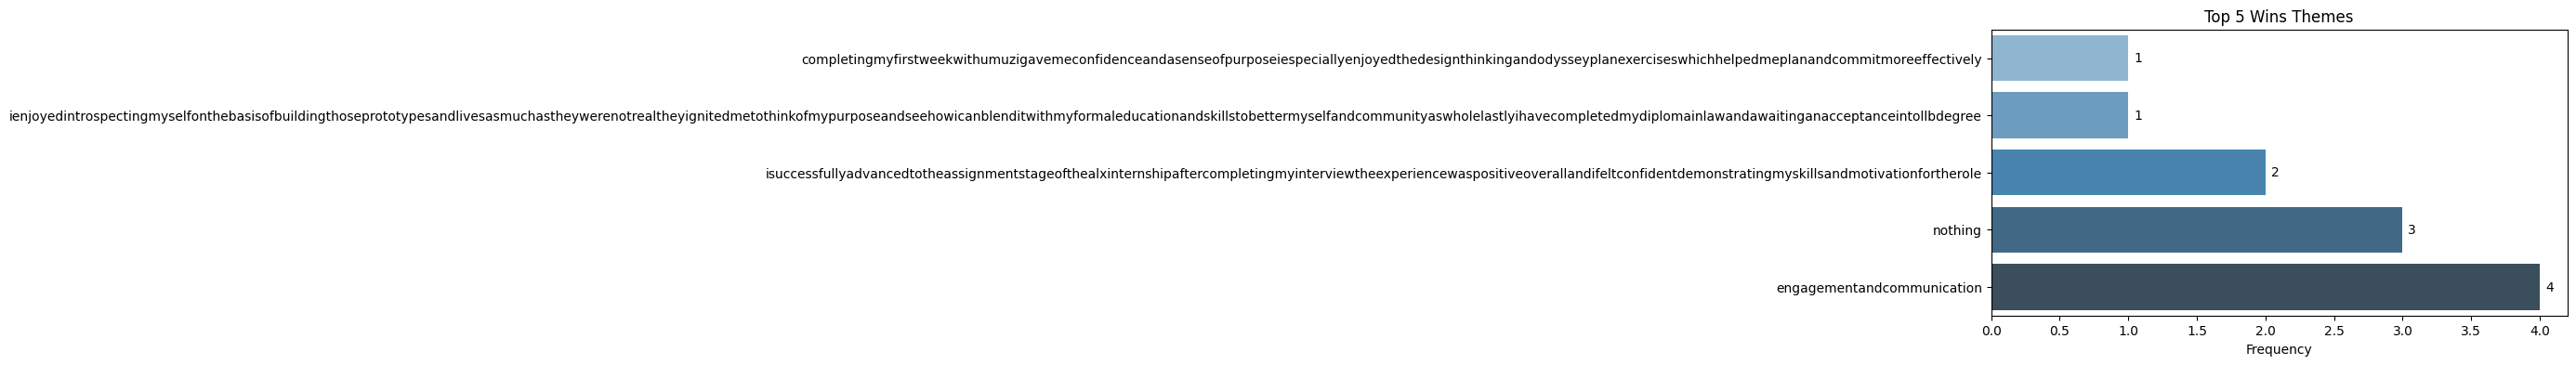

C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32156\2892266305.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='count', y='token', data=df_plot_top, palette=palette)


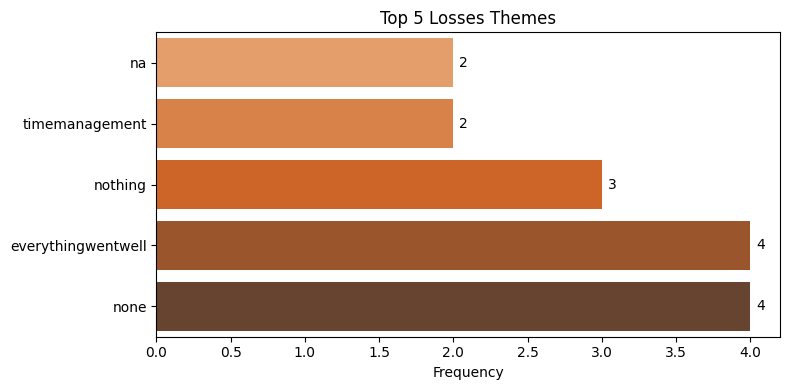

C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32156\2892266305.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='count', y='token', data=df_plot_top, palette=palette)


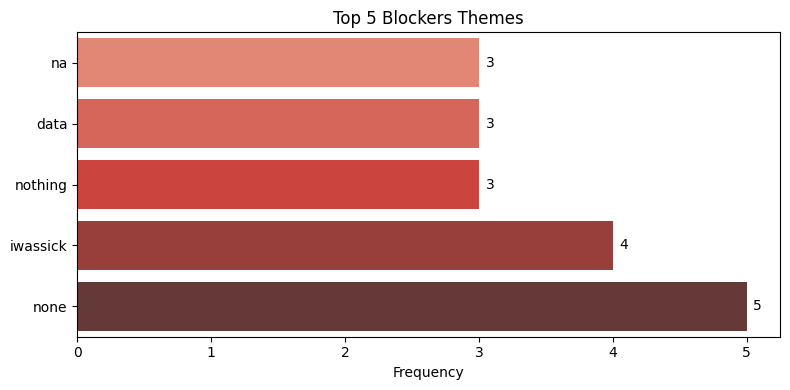

In [ ]:
# VISUALIZATIONS

# Helper: plot top-N tokens from a list of (token, count) tuples as a clean horizontal bar chart
def plot_top_from_tuples(tuples_list, title, top_n=5, palette='viridis'):
    if not tuples_list:
        print(f'No data for {title}')
        return
    df_plot = _pd.DataFrame(tuples_list, columns=['token', 'count'])
    df_plot = df_plot.sort_values('count')  # ascending for horizontal plot
    df_plot_top = df_plot.tail(top_n)
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x='count', y='token', data=df_plot_top, palette=palette)
    # Annotate counts on bars
    max_count = df_plot['count'].max() if not df_plot['count'].empty else 0
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + max_count * 0.01, p.get_y() + p.get_height() / 2, int(width), va='center')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# Plot the top-5 themes clearly
plot_top_from_tuples(wins_top5, 'Top 5 Wins Themes', top_n=5, palette='Blues_d')
plot_top_from_tuples(losses_top5, 'Top 5 Losses Themes', top_n=5, palette='Oranges_d')
plot_top_from_tuples(blockers_top5, 'Top 5 Blockers Themes', top_n=5, palette='Reds_d')


C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32076\2327821740.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')
C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32076\2327821740.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32076\2327821740.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


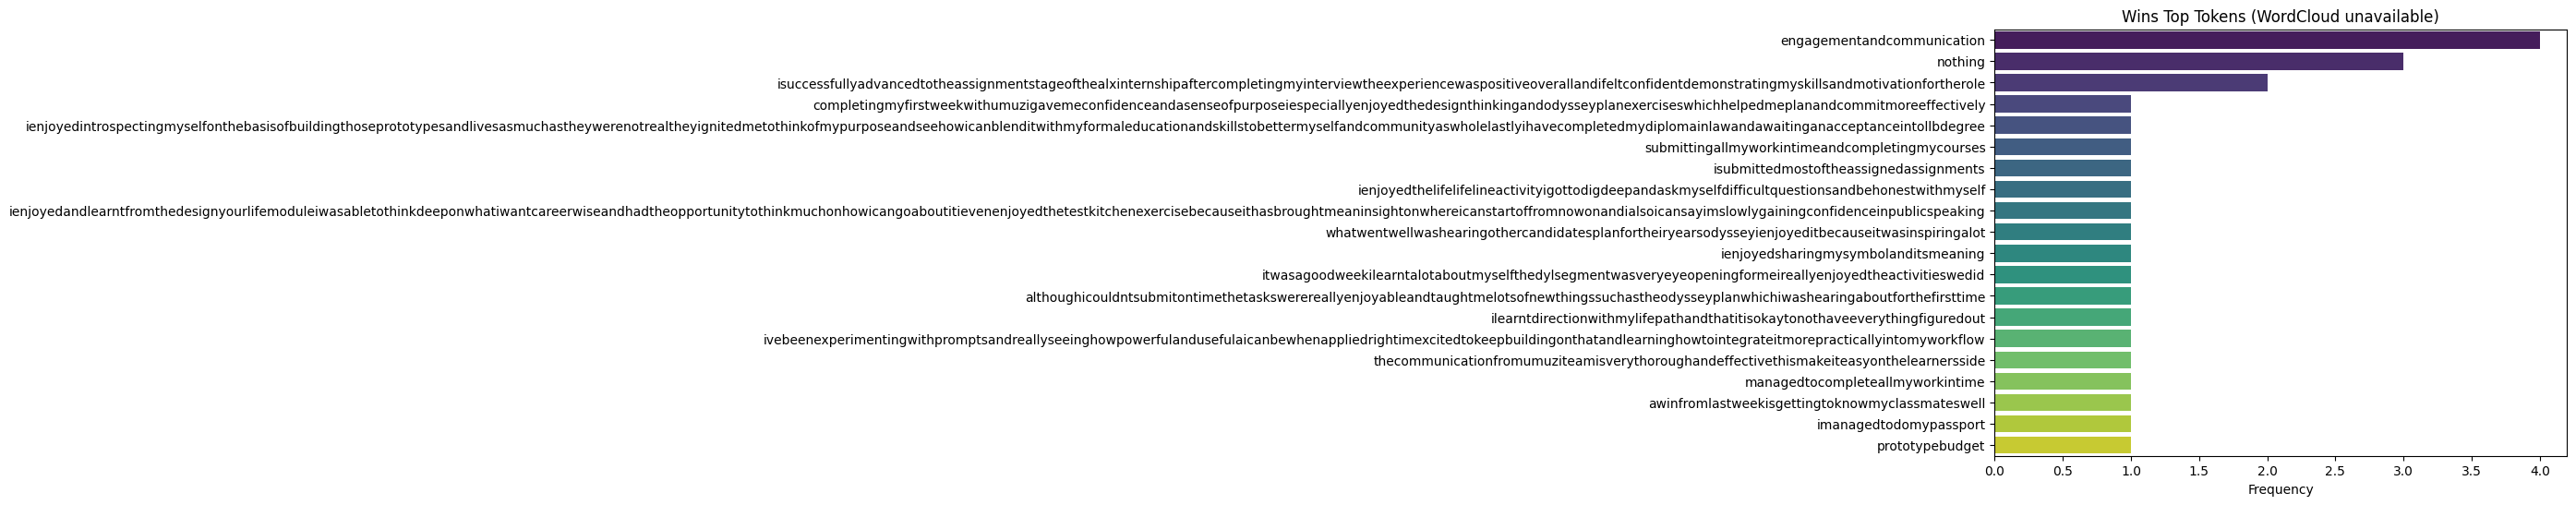

C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32076\2327821740.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')
C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32076\2327821740.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32076\2327821740.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


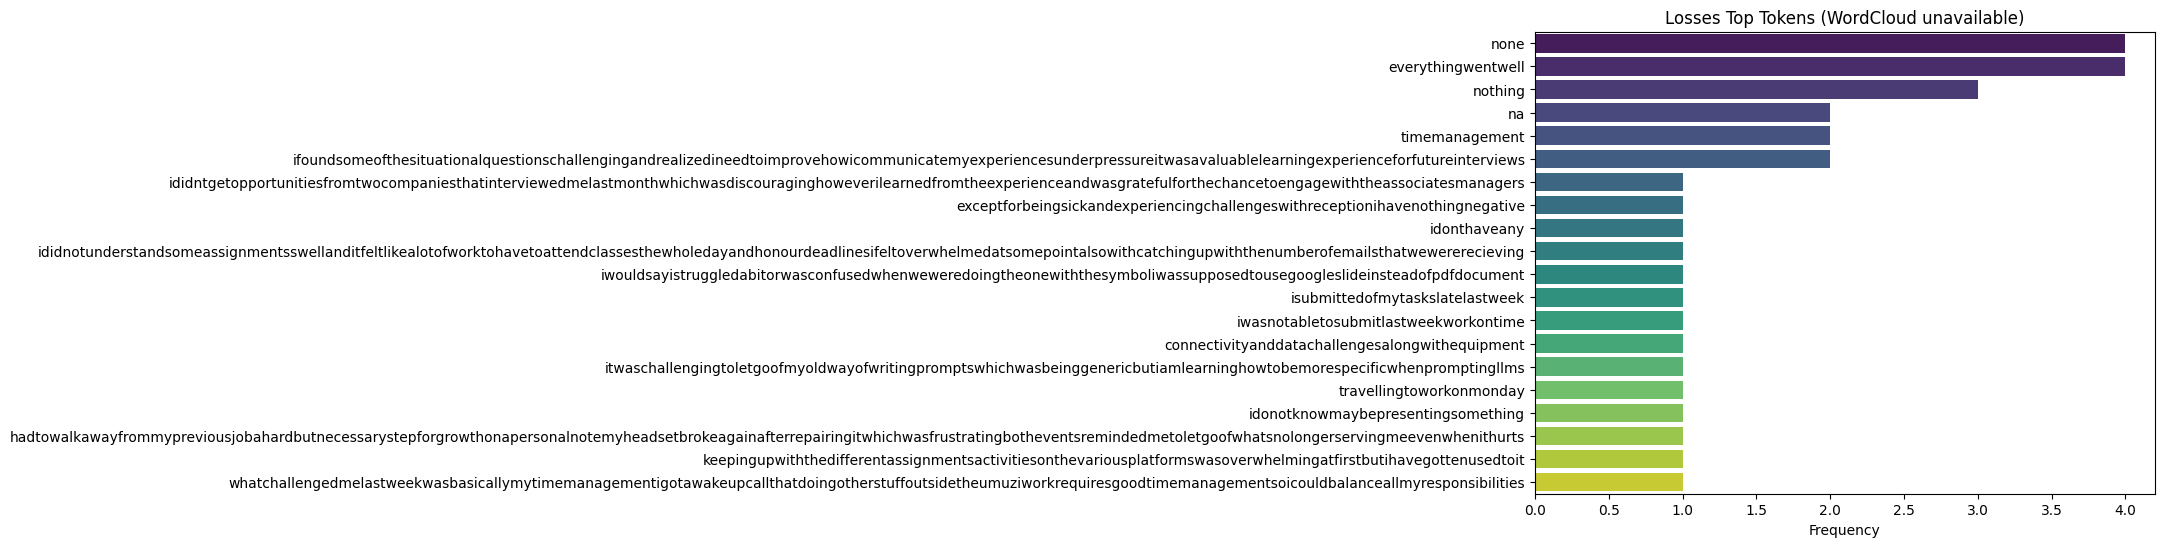

C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32076\2327821740.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')
C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32076\2327821740.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\Geeks2_PC12\AppData\Local\Temp\ipykernel_32076\2327821740.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


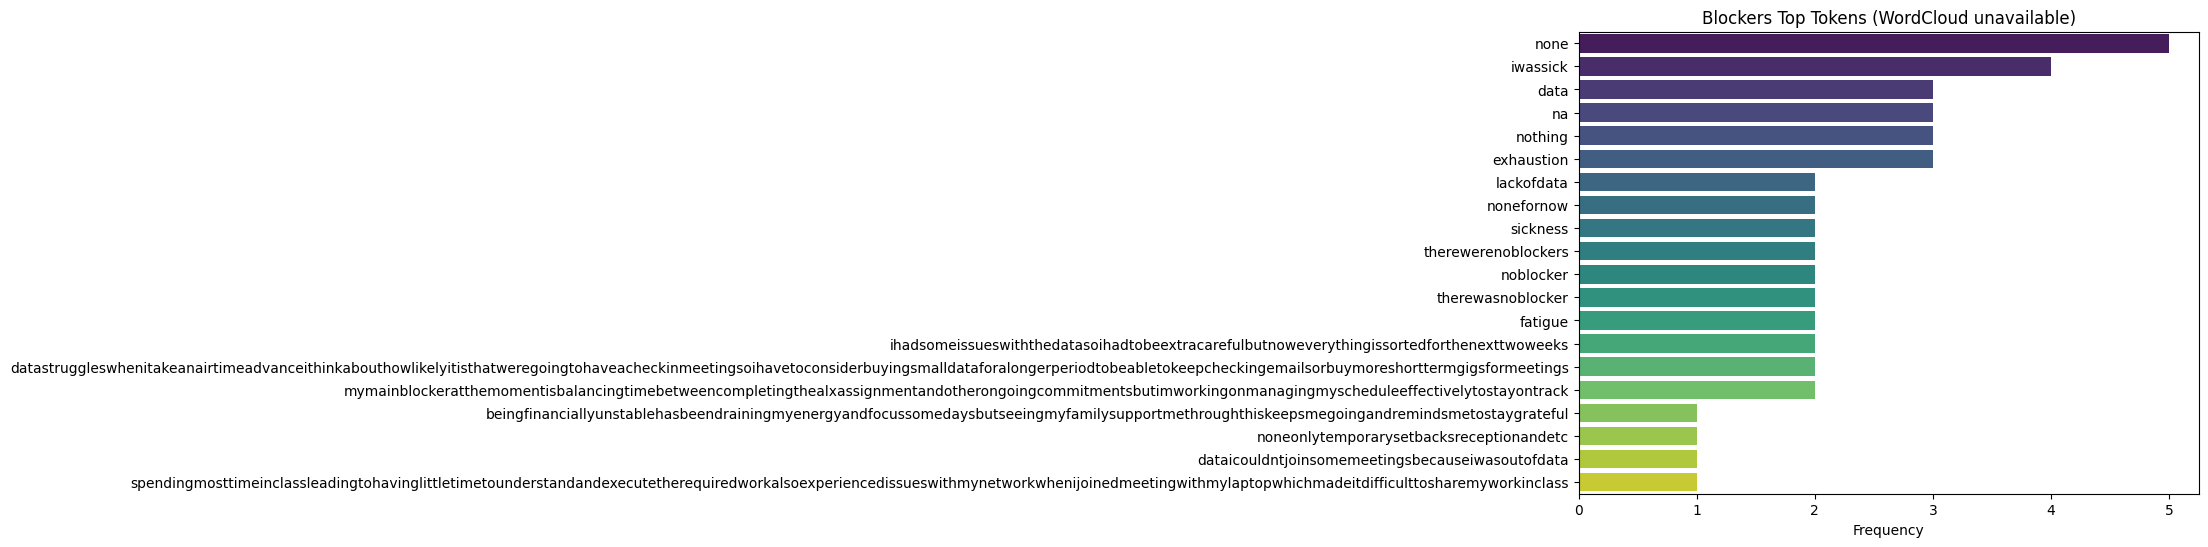

In [17]:

# Word Clouds (fallback to bar chart if WordCloud unavailable)
for name, tokens in [('Wins', wins_tokens), ('Losses', losses_tokens), ('Blockers', blockers_tokens)]:
    if 'WordCloud' in globals() and WordCloud is not None:
        wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{name} Word Cloud")
        plt.show()
    else:
        # Fallback: show top tokens as a horizontal bar chart
        from collections import Counter as _Counter
        top = _Counter(tokens).most_common(20)
        if len(top) == 0:
            print(f"No tokens to display for {name}.")
            continue
        words = [w for w,c in top]
        counts = [c for w,c in top]
        plt.figure(figsize=(8,6))
        sns.barplot(x=counts, y=words, palette='viridis')
        plt.title(f"{name} Top Tokens (WordCloud unavailable)")
        plt.xlabel('Frequency')
        plt.tight_layout()
        plt.show()




 ### INSIGHTS & RECOMMENDATIONS

Recommendations

1. Improve internet/data support for students (frequent blocker).
2. Offer time management workshops (common loss theme).
3. Provide financial assistance or guidance (blocker and loss theme).
4. Enhance clarity in instructions and resources (loss theme).
5. Continue motivational and career planning activities (win theme).


In [ ]:

# EXPORT RESULTS
# Save summary as JSON
import json
summary = {
    'wins_top5': wins_top5,
    'losses_top5': losses_top5,
    'blockers_top5': blockers_top5,
    'wins_sentiment': wins_summary,
    'losses_sentiment': losses_summary
}
with open('analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)
